In [1]:
!pip install keras-tuner

In [2]:
# Then import
from keras_tuner import Hyperband
from tensorflow.keras import layers, models

In [3]:
# Step 1: Environment Setup
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Verify GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
# Step 3: Configuration
DATA_PATH = r"F:\Firefox downloader\Projects\Project 2 - Music Genre Indentification\genres"
SAMPLE_RATE = 22050
DURATION = 30  # Seconds
N_MELS = 128
N_MFCC = 40
MAX_FRAMES = 130  # Time steps
BATCH_SIZE = 8
EPOCHS = 50

In [11]:
# Step 4: Enhanced Feature Extraction
def extract_combined_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
        # Extract multiple features
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
        log_mel = librosa.power_to_db(mel, ref=np.max)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        
        # Stack features vertically
        features = np.vstack([log_mel, mfcc, chroma, contrast])
        
        # Pad/truncate to fixed size
        if features.shape[1] < MAX_FRAMES:
            features = np.pad(features, ((0, 0), (0, MAX_FRAMES - features.shape[1])), mode='constant')
        else:
            features = features[:, :MAX_FRAMES]
            
        return features.T  # Transpose to (time, features)
    
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

In [12]:
# Step 2: Feature Extraction (Insert Enhanced Features)
def extract_combined_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    
    # Combine multiple feature types
    features = {
        'mel': librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128),
        'mfcc': librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40),
        'chroma': librosa.feature.chroma_stft(y=y, sr=sr),
        'contrast': librosa.feature.spectral_contrast(y=y, sr=sr)
    }
    
    # Stack and normalize features
    stacked = np.vstack([
        librosa.power_to_db(features['mel']),
        features['mfcc'],
        features['chroma'],
        features['contrast']
    ])
    
    # Pad/truncate
    if stacked.shape[1] < MAX_FRAMES:
        stacked = np.pad(stacked, ((0,0), (0, MAX_FRAMES - stacked.shape[1])))
    else:
        stacked = stacked[:, :MAX_FRAMES]
    
    return stacked[..., np.newaxis]  # Add channel dimension


In [13]:
# Step 5: Dataset Preparation
def prepare_dataset(data_path):
    genres = [d for d in os.listdir(data_path) 
             if os.path.isdir(os.path.join(data_path, d))]
    
    features = []
    labels = []
    
    print("Processing audio files...")
    for genre in genres:
        genre_path = os.path.join(data_path, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) 
                if f.endswith('.au')]
        
        for file in tqdm(files, desc=genre):
            spec = extract_combined_features(file)
            if spec is not None:
                features.append(spec)
                labels.append(genre)
    
    # Convert to numpy arrays
    X = np.array(features)
    y = np.array(labels)
    
    # Add channel dimension (CNN expects 3D: height, width, channels)
    X = X[..., np.newaxis]
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_categorical = to_categorical(y_encoded)
    
    return X, y_categorical, le, genres

In [14]:
from tensorflow.keras.utils import to_categorical

In [15]:
# Step 6: Load and Prepare Data
X, y, label_encoder, class_names = prepare_dataset(DATA_PATH)
print(f"Dataset shape: {X.shape}")
print(f"Class names: {class_names}")

Processing audio files...


rock: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s]

Dataset shape: (1000, 187, 130, 1, 1)
Class names: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [16]:
# Step 7: Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=np.argmax(y, axis=1), random_state=42
)
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

Train shape: (800, 187, 130, 1, 1), Validation shape: (200, 187, 130, 1, 1)


In [18]:
# # Fix input data shape (do this ONCE before model building)
# X_train = np.squeeze(X_train, axis=-1)
# X_val = np.squeeze(X_val, axis=-1)

# # Check shapes
# print("X_train shape after squeeze:", X_train.shape)  # (samples, height, width, 1)
# print("X_val shape after squeeze:", X_val.shape)

# # Define input shape for model
# input_shape = X_train.shape[1:]
# print("Corrected input shape:", input_shape)



X_train shape after squeeze: (800, 187, 130)
X_val shape after squeeze: (200, 187, 130)
Corrected input shape: (187, 130)


In [23]:
# After train/validation split
print("Shapes before adjustment:")
print("X_train:", X_train.shape, "X_val:", X_val.shape)

# Add channel dimension if needed
if X_train.ndim == 3:
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)

print("Shapes after adjustment:")
print("X_train:", X_train.shape, "X_val:", X_val.shape)

Shapes before adjustment:
X_train: (800, 187, 130) X_val: (200, 187, 130)
Shapes after adjustment:
X_train: (800, 187, 130, 1) X_val: (200, 187, 130, 1)


In [24]:
from sklearn.utils.class_weight import compute_class_weight

In [25]:
# Step 8: Compute Class Weights
# Get integer class labels from one-hot encoded y_train
y_train_labels = np.argmax(y_train, axis=1)

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}


In [33]:
# Step 9: Build Enhanced CNN Model
def build_enhanced_cnn(input_shape, num_classes):
    model = models.Sequential([
        # Layer 1: Maintain dimensions with padding
        layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Layer 2
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Layer 3: No final pooling
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Global pooling instead of flattening
        layers.GlobalAveragePooling2D(),
        
        # Dense layers
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.7),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model


# Initialize model
input_shape = X_train.shape[1:]
num_classes = len(class_names)
model = build_enhanced_cnn(input_shape, num_classes)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 187, 130, 64)      640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 93, 65, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_12 (Bat  (None, 93, 65, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 93, 65, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 93, 65, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 46, 32, 128)     

In [34]:
from tensorflow.keras import callbacks

In [35]:
# Step 10: Train Model with Callbacks
callbacks = [
    callbacks.EarlyStopping(patience=15, restore_best_weights=True, monitor='val_accuracy'),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


Epoch 1/50
100/100 [==============================] - 3s 20ms/step - loss: 3.5045 - accuracy: 0.1963 - val_loss: 2.4191 - val_accuracy: 0.2350 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 2s 17ms/step - loss: 3.1306 - accuracy: 0.2488 - val_loss: 2.0417 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 2s 18ms/step - loss: 2.8562 - accuracy: 0.2738 - val_loss: 2.3530 - val_accuracy: 0.2750 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 2s 17ms/step - loss: 2.7190 - accuracy: 0.2837 - val_loss: 2.1302 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 2s 17ms/step - loss: 2.4683 - accuracy: 0.3288 - val_loss: 2.0459 - val_accuracy: 0.3950 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 2s 17ms/step - loss: 2.5398 - accuracy: 0.3600 - val_loss: 1.8771 - val_accuracy: 0.4350 - lr: 0.0010
Epoch 7/50
100/100 [==============================] - 2s 17ms/st

In [36]:
from sklearn.metrics import classification_report

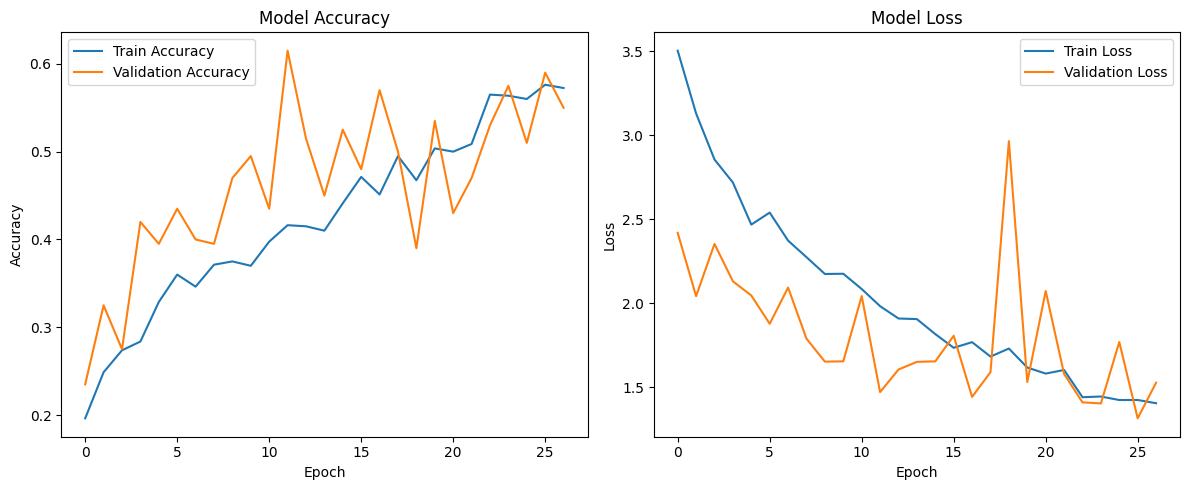

7/7 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

       blues       0.59      0.65      0.62        20
   classical       0.86      0.95      0.90        20
     country       0.57      0.40      0.47        20
       disco       0.60      0.15      0.24        20
      hiphop       0.55      0.80      0.65        20
        jazz       0.60      0.45      0.51        20
       metal       0.62      0.90      0.73        20
         pop       0.62      0.80      0.70        20
      reggae       0.67      0.70      0.68        20
        rock       0.41      0.35      0.38        20

    accuracy                           0.61       200
   macro avg       0.61      0.61      0.59       200
weighted avg       0.61      0.61      0.59       200



In [37]:
# Step 11: Evaluate Model
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Classification report
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print(classification_report(
    y_true_classes, y_pred_classes, 
    target_names=class_names
))

In [38]:
import joblib

In [39]:
# Step 12: Save Model
model.save("optimized_music_genre_cnn.h5")
joblib.dump(label_encoder, "label_encoder.pkl")
print("Model and label encoder saved.")

Model and label encoder saved.
